# Solving the Minimum Vertex Cover Problem

In this notebook, we will describe how to solve the **Minimum Vertex Cover** problem with LunaSolve. We will begin by defining, explaining and giving an example for the Minimum Vertex Cover problem. We will then continue by modeling a problem instance, optimize it and implement the solution using LunaSolve. Finally, we will also take a further look at the interpretation of the answer we are returned from Luna.


## Table of Contents

1. [Introduction](#1)
2. [A Real World Example](#2)
3. [Solving the Minimum Vertex Cover problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## **Minimum Vertex Cover** 
The **Minimum Vertex Cover** problem is a fundamental challenge in graph theory. It involves finding the smallest possible subset of vertices (nodes) in a graph so that every edge (connection between nodes) is "covered" by at least one of these vertices. This problem is widely applicable in various scenarios, including network security and efficient resource allocation.

Let’s define this clearly: Consider an undirected graph $G = (V, E)$, where $V$ is the set of vertices and $E$ is the set of edges. A *vertex cover* is a subset of vertices $C \subseteq V$ that includes at least one endpoint of every edge in the graph. The objective of the Minimum Vertex Cover problem is to identify the smallest such subset $C$ that ensures coverage of all edges, minimizing the size $|C|$.

<a id="2"></a>
## 2. A Real World Example

To make this clearer, let's explore a practical scenario. Imagine managing a network of computers. Each connection between computers could represent a potential security vulnerability. Your task is to monitor the smallest possible number of computers (nodes) while ensuring every connection (edge) is secured. Essentially, you're looking for the minimal number of computers you must supervise to oversee all network connections.

This real-world scenario precisely illustrates the essence of the Minimum Vertex Cover problem, finding the smallest group of nodes that effectively "covers" every edge in a network.

Next, we'll create a graph that represents such a computer network. Imagine we have 10 computers, each represented as a node, with edges indicating connections between them. In the following steps we will use Python's `networkx` library to build this graph and visualize it clearly using `matplotlib`.

<a id="3"></a>
## 3. Solving the Minimum Vertex Cover problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna-quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna-quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Minimum Vertex Cover problem using LunaSolve. First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [2]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Create a Minimum Vertex Cover problem

To set up a Minimum Vertex Cover scenario, all we need is a graph composed of nodes and edges. In this notebook, we'll construct a network of 10 computers labeled from 0 to 9, where each node represents a computer. Connections between pairs of computers are represented as edges between nodes.

Once we define the graph, we'll visualize it to clearly illustrate these connections. With the visualization complete, we’ll move forward to find out exactly how many computers must be monitored to ensure every connection in our network is secure.

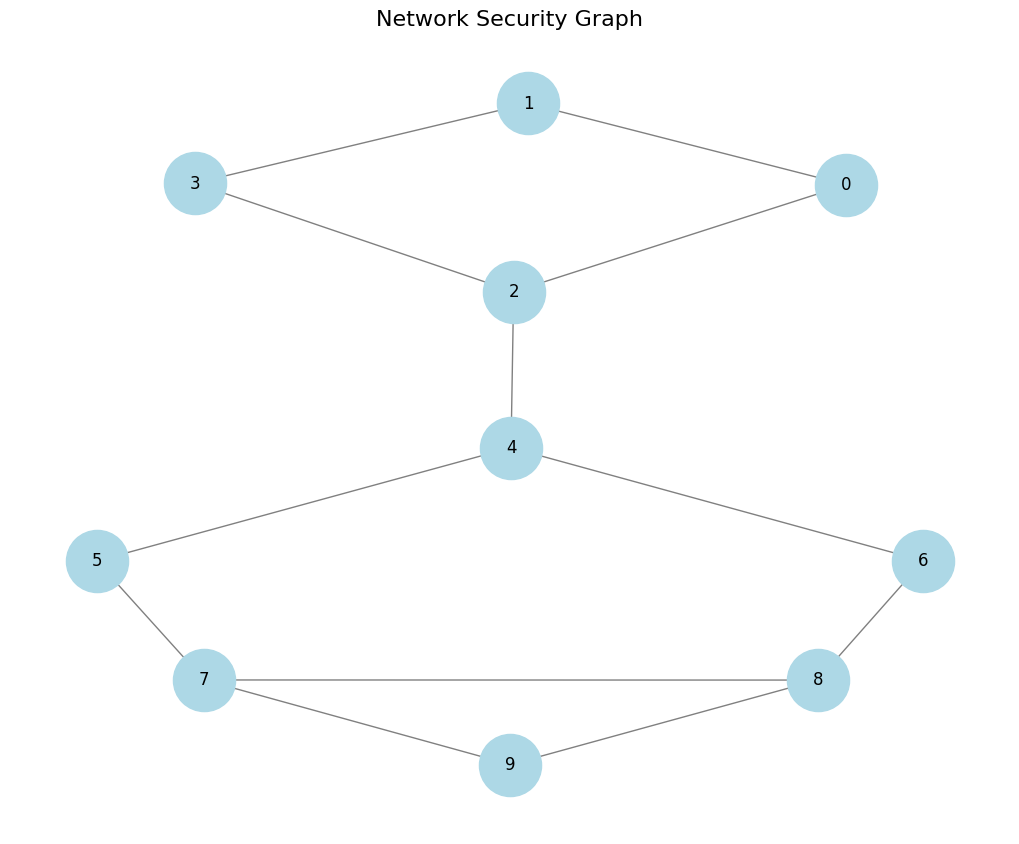

In [4]:
# Import the necessary packages
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
mvc_graph = nx.Graph()

# Add the nodes of the graph, which represent the computers in the example.
computers = list([f"{i}" for i in range(10)])
mvc_graph.add_nodes_from(computers)

# Add the edges to the graph, which represent the connection between the computers.
connections = [
    ("0", "1"),
    ("0", "2"),
    ("1", "3"),
    ("2", "3"),
    ("2", "4"),
    ("4", "5"),
    ("4", "6"),
    ("5", "7"),
    ("6", "8"),
    ("7", "8"),
    ("7", "9"),
    ("8", "9")
]
mvc_graph.add_edges_from(connections)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(mvc_graph, seed=42)
nx.draw(
    mvc_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightblue", font_color="black", edge_color="gray"
)
plt.title("Network Security Graph", fontsize=16)
plt.show()

### 3.3 Defining a Minimum Vertex Cover Object

The graph we've created represents a network of friendships. To identify the best way to partition this network, we'll define the Minimum Vertex Cover problem using LunaSolve's `MinimumVertexCover` class. This class converts the problem instance into an optimization problem, which Luna can then optimize.

When initializing the `MinimumVertexCover` object, ensure you pass the graph as a dictionary using NetworkX's `nx.to_dict_of_dicts()` method. Optionally, you can provide a descriptive `name` for your instance, if not specified, LunaSolve defaults it to `MVC` for MinimumVertexCover.

In [5]:
# Import the MinimumVertexCover object from the luna sdk
from luna_quantum.solve.use_cases import MinimumVertexCover

# Create a MinimumVertexCover object, to use within the luna_sdk for optimisation
mvc = MinimumVertexCover(graph=nx.to_dict_of_dicts(mvc_graph))


### 3.4 Uploading the Use Case Model to Luna 

Now, let's upload our Minimum Vertex Cover problem to Luna as an optimization task. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization. 

In [6]:
# Initiliaze the optimization object using the created use case instance
model = ls.model.create_from_use_case(name="Minimum Vertex Cover", use_case=mvc)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. In order to succesfully create a job, we must first select an algorithm for the optimization from LunaSolve's collection, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Minimum Vertex Cover problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we exectue the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name`for the job for easy identification. 

In [7]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model.id, name="Minimum Vertex Cover with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution`object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

In the case of the Minimum Vertex Cover problem, the `representation` is a list which contains the indices of all nodes that are included in the smallest cover. In other words, the representation is a list of all indices $i$, for which their decision variable $x_i$ is equal to one. 

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [ ]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

To better grasp the solution, we can visualize again the computer network using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1 green.

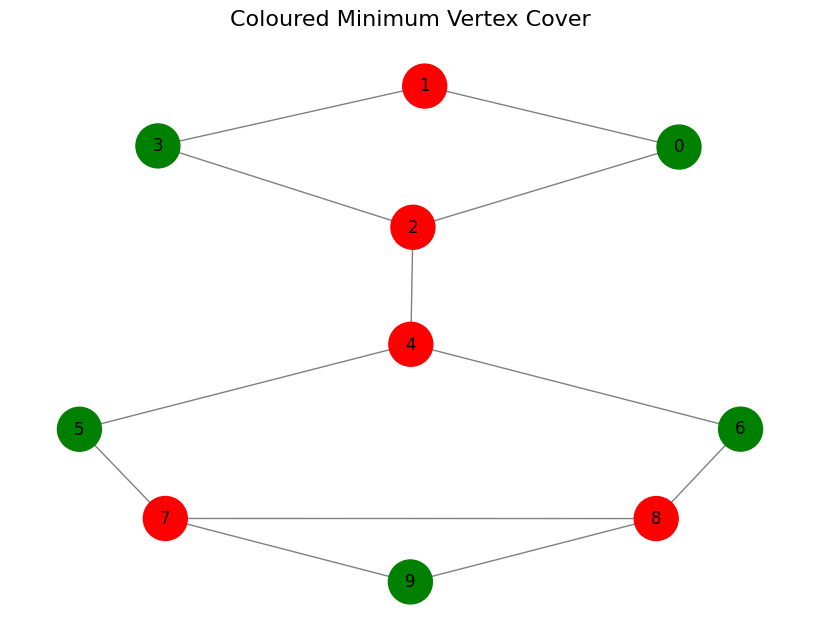

In [15]:
# Give each node a colour based on the value of the decision variable
colour_list = []
for node in mvc_graph.nodes:
    if int(node) in best_use_case_result["solution"]:
        colour_list.append("green")
    else:
        colour_list.append("red")

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(mvc_graph, pos, with_labels=True, node_color=colour_list, edge_color="gray", node_size=1000, font_size=12)
plt.title("Coloured Minimum Vertex Cover", fontsize=16)
plt.show()